In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

import sys
sys.path.append('..')
from d2l_helpers import *

In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/Users/zhuyuezx/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zhuyuezx/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [4]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [5]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [6]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

img = torchvision.transforms.ToTensor()(Image.open('../data/images/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


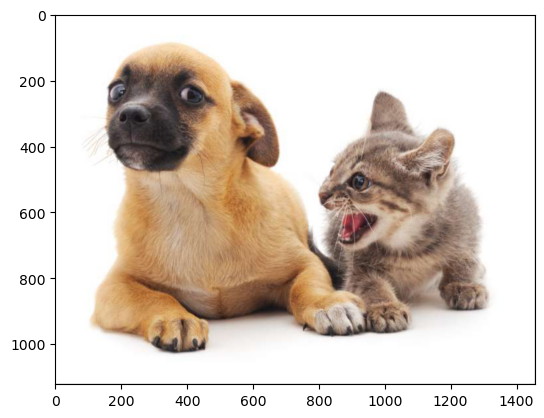

In [7]:
print('input image shape:', img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
plt.imshow(out_img);

In [8]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [9]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [10]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, [get_device()]
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

training on [device(type='mps')]
iter: 5, loss 1.920, train acc 0.618
iter: 11, loss 1.557, train acc 0.674
iter: 17, loss 1.365, train acc 0.707
iter: 23, loss 1.258, train acc 0.723
iter: 29, loss 1.157, train acc 0.739
iter: 33, loss 1.107, train acc 0.746
epoch 0, loss 1.107, train acc 0.746, test acc 0.806
iter: 5, loss 0.617, train acc 0.831
iter: 11, loss 0.633, train acc 0.829
iter: 17, loss 0.632, train acc 0.826
iter: 23, loss 0.613, train acc 0.830
iter: 29, loss 0.619, train acc 0.828
iter: 33, loss 0.615, train acc 0.828
epoch 1, loss 0.615, train acc 0.828, test acc 0.834
iter: 5, loss 0.551, train acc 0.842
iter: 11, loss 0.522, train acc 0.851
iter: 17, loss 0.530, train acc 0.848
iter: 23, loss 0.527, train acc 0.847
iter: 29, loss 0.525, train acc 0.847
iter: 33, loss 0.524, train acc 0.846
epoch 2, loss 0.524, train acc 0.846, test acc 0.845
iter: 5, loss 0.457, train acc 0.860
iter: 11, loss 0.459, train acc 0.860
iter: 17, loss 0.459, train acc 0.859
iter: 23, loss

In [11]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [12]:
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

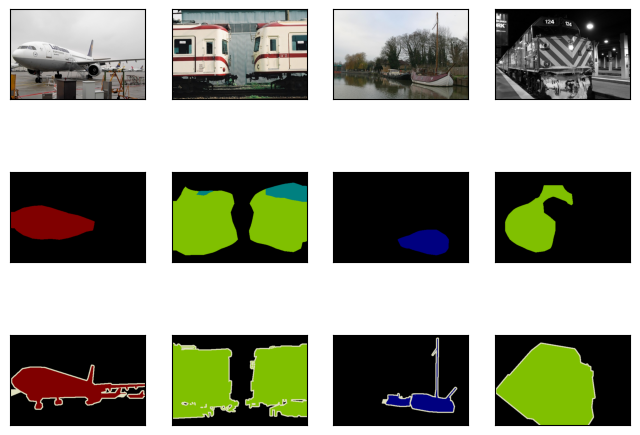

In [13]:
voc_dir = '../data/VOCdevkit/VOC2012'
test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);